In [7]:
import requests

import matplotlib.pyplot as plt
import seaborn as sns

import umap, numpy as np, pandas as pd

from nltk import FreqDist

import pandas as pd

from sklearn.decomposition import TruncatedSVD
from scipy import sparse
import numpy as np

from collections import Counter
from scipy.sparse import csr_matrix

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [8]:
import warnings
warnings.filterwarnings('ignore')

# Or for specific warning types:
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [9]:
labyrinthus_df = pd.read_parquet("../data/large_files/labyrinthus_embeddings.parquet")

In [10]:
labyrinthus_df.columns

Index(['author', 'title', 'grela_id', 'sentence_id', 'sentence_text',
       'context_3sents', 'tokens', 'concordance_tokens', 'not_before',
       'not_after', 'date_random', 'lagt_genre', 'lagt_provenience',
       'noscemus_genre', 'noscemus_discipline', 'target_token_id',
       'target_char_start', 'target_char_end', 'classification_single',
       'classification_single_label', 'xlmr_sentence', 'xlmr_sp_tokens',
       'xlmr_aug_tokens', 'embed_l5', 'att_l5', 'embed_l6', 'att_l6',
       'embed_l7', 'att_l7', 'embed_l8', 'att_l8', 'embed_l9', 'att_l9',
       'embed_l10', 'att_l10', 'embed_l11', 'att_l11', 'xlmr_conc_text',
       'xlmr_conc_sp_tokens', 'xlmr_conc_aug_tokens', 'embed_conc_l5',
       'att_conc_l5', 'embed_conc_l6', 'att_conc_l6', 'embed_conc_l7',
       'att_conc_l7', 'embed_conc_l8', 'att_conc_l8', 'embed_conc_l9',
       'att_conc_l9', 'embed_conc_l10', 'att_conc_l10', 'embed_conc_l11',
       'att_conc_l11', 'att_l5_raw_embed', 'att_l6_raw_embed',
       'att_

## Supervised classification

In [22]:
### features:
sentence_contextual_embeddings = ['embed_l6', 'embed_l7', 'embed_l8', 'embed_l9',  'embed_l10', 'embed_l11']

sentence_attention_embeddings = ['att_l6_svd400_embed', 'att_l7_svd400_embed',
       'att_l8_svd400_embed', 'att_l9_svd400_embed', 'att_l10_svd400_embed',
       'att_l11_svd400_embed']

concordance_contextual_embeddings = ['embed_conc_l6', 'att_conc_l6', 'embed_conc_l7',
       'att_conc_l7', 'embed_conc_l8', 'att_conc_l8', 'embed_conc_l9',
       'att_conc_l9', 'embed_conc_l10', 'att_conc_l10', 'embed_conc_l11']

concordance_attention_embeddings = ['att_conc_l6_svd400_embed', 'att_conc_l7_svd400_embed',
       'att_conc_l8_svd400_embed', 'att_conc_l9_svd400_embed',
       'att_conc_l10_svd400_embed', 'att_conc_l11_svd400_embed']

In [12]:
# ------------------------------------------------------------------
# common objects
# ------------------------------------------------------------------
y  = labyrinthus_df["classification_single"].values           # 21 classes incl. “other”
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe = make_pipeline(
    StandardScaler(with_mean=False),
    LogisticRegression(max_iter=4000,
                       multi_class="multinomial",
                       solver="lbfgs",
                       n_jobs=-1)
)

In [115]:
labyrinthus_df.columns

Index(['author', 'title', 'grela_id', 'sentence_id', 'sentence_text',
       'context_3sents', 'tokens', 'concordance_tokens', 'not_before',
       'not_after', 'date_random', 'lagt_genre', 'lagt_provenience',
       'noscemus_genre', 'noscemus_discipline', 'target_token_id',
       'target_char_start', 'target_char_end', 'classification_single',
       'classification_single_label', 'xlmr_sentence', 'xlmr_sp_tokens',
       'xlmr_aug_tokens', 'embed_l5', 'att_l5', 'embed_l6', 'att_l6',
       'embed_l7', 'att_l7', 'embed_l8', 'att_l8', 'embed_l9', 'att_l9',
       'embed_l10', 'att_l10', 'embed_l11', 'att_l11', 'xlmr_conc_text',
       'xlmr_conc_sp_tokens', 'xlmr_conc_aug_tokens', 'embed_conc_l5',
       'att_conc_l5', 'embed_conc_l6', 'att_conc_l6', 'embed_conc_l7',
       'att_conc_l7', 'embed_conc_l8', 'att_conc_l8', 'embed_conc_l9',
       'att_conc_l9', 'embed_conc_l10', 'att_conc_l10', 'embed_conc_l11',
       'att_conc_l11', 'att_l5_raw_embed', 'att_l6_raw_embed',
       'att_

In [119]:
# ------------------------------------------------------------------
# Concatenated features: Contextual + Attention (Layer 11)
# ------------------------------------------------------------------
X = np.stack(labyrinthus_df["svd400"].values)                 # shape (N, 768)

# Concatenate along feature axis → shape (N, 1168)
X_combined = np.concatenate([X], axis=1)

y  = labyrinthus_df["classification_single_label"].values           # 21 classes incl. “other”


# Evaluate
f1_combined = cross_val_score(pipe, X_combined, y, cv=cv, scoring="f1_macro").mean()
print(f"Baseline F1 macro= {f1_combined:.4f}")

Baseline F1 macro= 0.3545


In [19]:
# ------------------------------------------------------------------
# Concatenated features: Contextual + Attention (Layer 11)
# ------------------------------------------------------------------
X_embed = np.stack(labyrinthus_df["embed_conc_l11"].values)                 # shape (N, 768)
X_attn  = np.stack(labyrinthus_df["att_conc_l11_svd400_embed"].values)      # shape (N, 400)

# Concatenate along feature axis → shape (N, 1168)
X_combined = np.concatenate([X_embed, X_attn], axis=1)

# Evaluate
f1_combined = cross_val_score(pipe, X_combined, y, cv=cv, scoring="f1_macro").mean()
print(f"Layer 11 (combined): F1_macro = {f1_combined:.4f}")

Layer 11 (combined): F1_macro = 0.4033


In [25]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Initialize CV and target
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y = labyrinthus_df["classification_single"].values

# Define input features
all_features = {
    "sent_ctx": sentence_contextual_embeddings,
    "sent_att": sentence_attention_embeddings,
    "conc_ctx": concordance_contextual_embeddings[::2],  # only embeddings
    "conc_att": concordance_attention_embeddings,
}

# Classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=4000, multi_class="multinomial", solver="lbfgs", n_jobs=-1),
    "LinearSVC": LinearSVC(max_iter=4000, dual=False)
}

# Collect results
results = []

for source, cols in all_features.items():
    for col in cols:
        X = np.stack(labyrinthus_df[col].values)
        X_scaled = StandardScaler(with_mean=False).fit_transform(X)
        for clf_name, clf in classifiers.items():
            y_pred = cross_val_predict(clf, X_scaled, y, cv=cv)
            acc = accuracy_score(y, y_pred)
            f1 = f1_score(y, y_pred, average="macro")
            results.append((source, col, clf_name, acc, f1))

# Results summary
results_independent_df = pd.DataFrame(results, columns=["context", "feature", "classifier", "accuracy", "f1_macro"])
results_independent_df

,context,feature,classifier,accuracy,f1_macro
0,sent_ctx,embed_l6,LogisticRegression,0.486900,0.336805
1,sent_ctx,embed_l6,LinearSVC,0.467249,0.331687
2,sent_ctx,embed_l7,LogisticRegression,0.493450,0.347568
3,sent_ctx,embed_l7,LinearSVC,0.484716,0.352115
4,sent_ctx,embed_l8,LogisticRegression,0.482533,0.372390
5,sent_ctx,embed_l8,LinearSVC,0.465066,0.352629
6,sent_ctx,embed_l9,LogisticRegression,0.504367,0.389683
7,sent_ctx,embed_l9,LinearSVC,0.480349,0.374440
8,sent_ctx,embed_l10,LogisticRegression,0.497817,0.347348
9,sent_ctx,embed_l10,LinearSVC,0.486900,0.354883


In [89]:
results_independent_df.to_csv("../data/labyrinthus_classification_results_independent.csv", index=False)

In [28]:
combined_results = []

for L in range(6, 12):
    # sentence context
    X_ctx = np.stack(labyrinthus_df[f"embed_l{L}"].values)
    X_att = np.stack(labyrinthus_df[f"att_l{L}_svd400_embed"].values)
    X = np.concatenate([X_ctx, X_att], axis=1)
    X_scaled = StandardScaler(with_mean=False).fit_transform(X)

    for clf_name, clf in classifiers.items():
        y_pred = cross_val_predict(clf, X_scaled, y, cv=cv)
        acc = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred, average="macro")
        combined_results.append((f"sentence_L{L}", clf_name, acc, f1))

    # concordance context
    X_ctx = np.stack(labyrinthus_df[f"embed_conc_l{L}"].values)
    X_att = np.stack(labyrinthus_df[f"att_conc_l{L}_svd400_embed"].values)
    X = np.concatenate([X_ctx, X_att], axis=1)
    X_scaled = StandardScaler(with_mean=False).fit_transform(X)

    for clf_name, clf in classifiers.items():
        y_pred = cross_val_predict(clf, X_scaled, y, cv=cv)
        acc = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred, average="macro")
        combined_results.append((f"concordance_L{L}", clf_name, acc, f1))

# Display
combined_df = pd.DataFrame(combined_results, columns=["combo", "classifier", "accuracy", "f1_macro"])

KeyboardInterrupt: 

In [109]:
combined_df

,combo,classifier,accuracy,f1_macro
0,sentence_L6,LogisticRegression,0.538210,0.411450
1,sentence_L6,LinearSVC,0.515284,0.402585
2,concordance_L6,LogisticRegression,0.548035,0.411323
3,concordance_L6,LinearSVC,0.516376,0.411692
4,sentence_L7,LogisticRegression,0.538210,0.411574
5,sentence_L7,LinearSVC,0.527293,0.438656
6,concordance_L7,LogisticRegression,0.550218,0.451794
7,concordance_L7,LinearSVC,0.525109,0.421798
8,sentence_L8,LogisticRegression,0.528384,0.399472
9,sentence_L8,LinearSVC,0.497817,0.393716


In [92]:
combined_df.to_csv("../data/combined_single-layers.csv", index=False)

In [39]:
labyrinthus_df_short = labyrinthus_df[labyrinthus_df["classification_single_label"].isin(["medical_anatomical","mythological", "metaphorical_general","geographical"])]
len(labyrinthus_df_short) / len(labyrinthus_df)

0.7205240174672489

In [85]:
def combined_layers(df, input, layer_range, svd, pipe=None, cv=None, clf=None):
    if pipe is None:
        pipe = make_pipeline(
            StandardScaler(with_mean=False),
            LogisticRegression(max_iter=4000,
                               multi_class="multinomial",
                               solver="lbfgs",
                               n_jobs=-1)
        )
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True)
    if clf is None:
        clf = LogisticRegression(max_iter=4000, multi_class="multinomial", solver="lbfgs", n_jobs=-1)

    if input == "sentence":
        X_stack = np.stack([np.stack(df[f"embed_l{L}"].values) for L in layer_range], axis=0)
        X_att_stack = np.stack([np.stack(df[f"att_l{L}_svd400_embed"].values) for L in layer_range], axis=0)
    else:
        X_stack = np.stack([np.stack(df[f"embed_conc_l{L}"].values) for L in layer_range], axis=0)
        X_att_stack = np.stack([np.stack(df[f"att_conc_l{L}_svd400_embed"].values) for L in layer_range], axis=0)

    # Reshape to (n_samples, total_features)
    X_stack = X_stack.transpose(1, 0, 2).reshape(len(df), -1)
    X_att_stack = X_att_stack.transpose(1, 0, 2).reshape(len(df), -1)

    # Concatenate embeddings and attentions
    X = np.concatenate([X_stack, X_att_stack], axis=1)

    # Normalize and reduce
    X_scaled = StandardScaler(with_mean=False).fit_transform(X)
    if svd:
        svd = TruncatedSVD(n_components=800, random_state=42)
        X_scaled = svd.fit_transform(X_scaled)
    y = df["classification_single_label"].values
    y_preds, f1s, accs = [], [], []
    for _ in range(10):
        y_pred = cross_val_predict(clf, X_scaled, y, cv=cv)
        acc = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred, average="macro")
        y_preds.append(y_pred)
        f1s.append(f1)
        accs.append(acc)
    return y_preds, f1s, accs

In [86]:
y_preds, f1s, accs = combined_layers(labyrinthus_df, "sentence", layer_range=range(7, 9), svd=True)
f1s

[0.4032171790180076,
 0.38507047031329417,
 0.3837455152385959,
 0.4314610866199769,
 0.38119408962115925,
 0.4340041667353793,
 0.45961275483336916,
 0.41663889575825036,
 0.414103964395645,
 0.44278344806773007]

In [120]:
results_dicts = []

for layer_range in [
    (6,6), (7,7), (8,8), (9,9), (10,10), (11,11),
    (6,7),(7, 8), (8, 9), (9, 10), (10, 11),
    (6,8),(7, 9), (8, 10), (9, 11),
    (6,9),(7, 10), (8, 11),
    (6,10),(7, 11),
    (6,11)
    ]:
    #for svd in [True, False]:
    y_preds, f1s, accs = combined_layers(labyrinthus_df, "sentence", layer_range=layer_range, svd=False)
    results_dicts.append({"Context": "sentence", "Layer range": layer_range, "y_preds" : y_preds, "Accuracies": np.mean(accs), "F1-macros": f1s, "F1_avr" : np.mean(f1s)})
    y_preds, f1s, accs = combined_layers(labyrinthus_df, "concordance", layer_range=layer_range, svd=False)
    results_dicts.append({"Context": "concordance", "Layer range": layer_range, "y_preds" : y_preds, "Accuracies": np.mean(accs), "F1-macros": f1s, "F1_avr" : np.mean(f1s)})

In [121]:
results_df = pd.DataFrame(results_dicts)
results_df

,Context,Layer range,y_preds,Accuracies,F1-macros,F1_avr
0,sentence,"(6, 6)","[[metaphorical_general, metaphorical_general, ...",0.534170,"[0.4287132960239554, 0.4197612538855159, 0.401...",0.402345
1,concordance,"(6, 6)","[[metaphorical_general, metaphorical_general, ...",0.532205,"[0.3923699064467322, 0.41858985959768064, 0.39...",0.400745
2,sentence,"(7, 7)","[[metaphorical_general, metaphorical_general, ...",0.539520,"[0.4313686024542906, 0.43665942696333754, 0.42...",0.429619
3,concordance,"(7, 7)","[[metaphorical_general, metaphorical_general, ...",0.519541,"[0.4078754258548839, 0.40811962700432575, 0.36...",0.399701
4,sentence,"(8, 8)","[[metaphorical_general, metaphorical_general, ...",0.521725,"[0.430975897789401, 0.43033965408836183, 0.431...",0.407748
5,concordance,"(8, 8)","[[metaphorical_general, spiritual_religious, m...",0.527948,"[0.4384224041372657, 0.40879735774140835, 0.42...",0.412273
6,sentence,"(9, 9)","[[metaphorical_general, mythological, metaphor...",0.525218,"[0.41040343080937997, 0.39844929970017245, 0.4...",0.414974
7,concordance,"(9, 9)","[[metaphorical_general, mythological, metaphor...",0.531550,"[0.451828513989122, 0.4329452866125177, 0.4337...",0.425644
8,sentence,"(10, 10)","[[metaphorical_general, mythological, spiritua...",0.548253,"[0.43058108176421095, 0.41343134018155603, 0.4...",0.426820
9,concordance,"(10, 10)","[[metaphorical_general, mythological, metaphor...",0.541703,"[0.39850341200157713, 0.44723034426319225, 0.4...",0.414783


In [122]:
results_df["best_perf_i"] =  results_df["F1-macros"].apply(lambda my_list: max(enumerate(my_list), key=lambda x: x[1])[0])

In [123]:
results_df["best_perf"] =  results_df["F1-macros"].apply(lambda my_list: max(enumerate(my_list), key=lambda x: x[1])[1])

In [124]:
results_df

,Context,Layer range,y_preds,Accuracies,F1-macros,F1_avr,best_perf_i,best_perf
0,sentence,"(6, 6)","[[metaphorical_general, metaphorical_general, ...",0.534170,"[0.4287132960239554, 0.4197612538855159, 0.401...",0.402345,0,0.428713
1,concordance,"(6, 6)","[[metaphorical_general, metaphorical_general, ...",0.532205,"[0.3923699064467322, 0.41858985959768064, 0.39...",0.400745,3,0.419482
2,sentence,"(7, 7)","[[metaphorical_general, metaphorical_general, ...",0.539520,"[0.4313686024542906, 0.43665942696333754, 0.42...",0.429619,8,0.456649
3,concordance,"(7, 7)","[[metaphorical_general, metaphorical_general, ...",0.519541,"[0.4078754258548839, 0.40811962700432575, 0.36...",0.399701,3,0.431403
4,sentence,"(8, 8)","[[metaphorical_general, metaphorical_general, ...",0.521725,"[0.430975897789401, 0.43033965408836183, 0.431...",0.407748,2,0.431843
5,concordance,"(8, 8)","[[metaphorical_general, spiritual_religious, m...",0.527948,"[0.4384224041372657, 0.40879735774140835, 0.42...",0.412273,4,0.448307
6,sentence,"(9, 9)","[[metaphorical_general, mythological, metaphor...",0.525218,"[0.41040343080937997, 0.39844929970017245, 0.4...",0.414974,2,0.442328
7,concordance,"(9, 9)","[[metaphorical_general, mythological, metaphor...",0.531550,"[0.451828513989122, 0.4329452866125177, 0.4337...",0.425644,0,0.451829
8,sentence,"(10, 10)","[[metaphorical_general, mythological, spiritua...",0.548253,"[0.43058108176421095, 0.41343134018155603, 0.4...",0.426820,6,0.437002
9,concordance,"(10, 10)","[[metaphorical_general, mythological, metaphor...",0.541703,"[0.39850341200157713, 0.44723034426319225, 0.4...",0.414783,7,0.448885


In [125]:
results_df.to_csv("../data/classification_combining-layers.csv", index=False)

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels(y_true, y_pred))
    labels = unique_labels(y_true, y_pred)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels, ax=ax)

    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title("Confusion Matrix")
    plt.xticks(rotation=45)
    plt.tight_layout()

    return fig


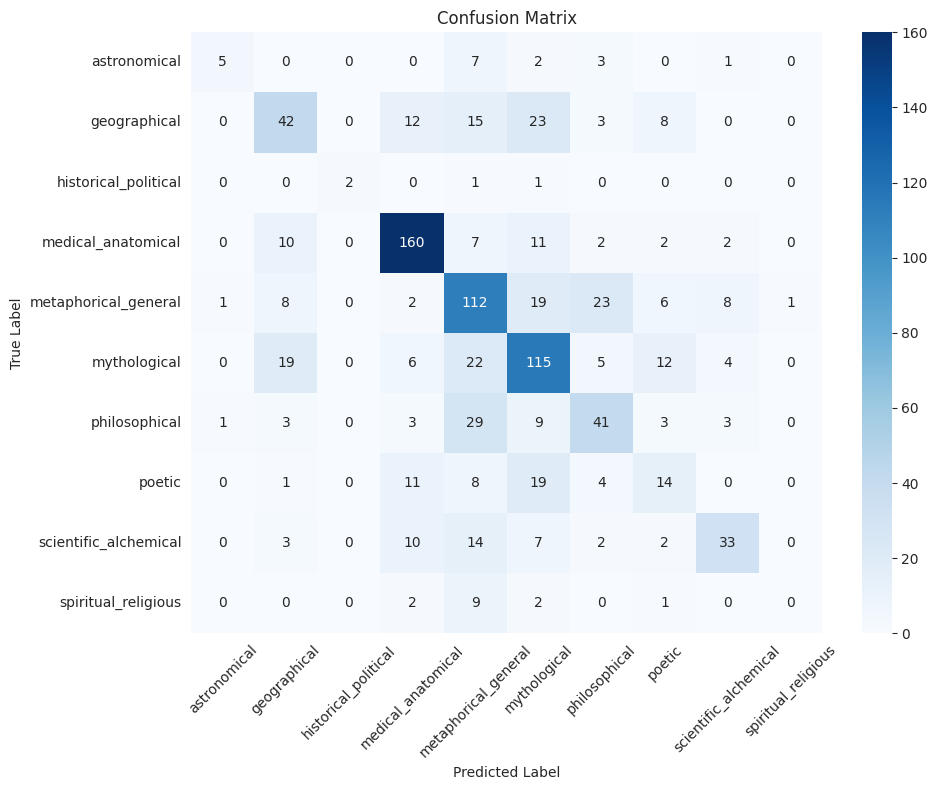

In [102]:
y_pred = results_df.iloc[21]["y_preds"][5]
fig = plot_confusion_matrix(labyrinthus_df["classification_single_label"], y_pred)
# fig.savefig("confusion_matrix.png")

In [103]:
fig.savefig("../figures/labyrinthus_classification_confusion_matrix_l8-12.png", dpi=300)

In [ ]:
fig.savefig("../figures/labyrinthus_classification_confusion_matrix_l8-12.png", dpi=300)

In [85]:
labyrinthus_df.head(5)

,author,title,grela_id,sentence_id,sentence_text,context_3sents,tokens,concordance_tokens,classification,not_before,...,embed_l8,att_l8,embed_l9,att_l9,embed_l10,att_l10,embed_l11,att_l11,svd300,svd400
0,Humbertus Silvae Candidae1010-1061,Adversus Simoniacos,cc_10012,cc_10012_2812,"Exploret qui potest qualiter, et qua hunc laby...","Si enim, ut philosophus allegat, qui non prohi...","[{'char_end': 8, 'char_start': 0, 'lemma': 'ex...","[{'char_end': 303, 'char_start': 299, 'lemma':...",metaphorical,1010.0,...,"[-0.5996939, -0.08402276, 0.24582314, 0.246073...","{'exploro': {'weight': 0.007501654326915741, '...","[-0.4901215, -0.014518358, 0.11257135, -0.0287...","{'exploro': {'weight': 0.0040437448769807816, ...","[-0.22389103, -0.08037936, 0.4684307, -0.07405...","{'exploro': {'weight': 0.0023853108286857605, ...","[0.015361398, -0.05652492, 0.28677505, -0.2481...","{'exploro': {'weight': 0.004686874337494373, '...","[1.0248758, -0.109425925, 0.18502058, -0.12902...","[1.0248758, -0.10942612, 0.18502046, -0.129020..."
1,Petrus Damianus,"Patrologia Latina, vol. 145",cc_10077,cc_10077_50,"Et poenae factus est auctor, qui poenalis laby...","Protinus igitur projectus in taurum, quod infe...","[{'char_end': 2, 'char_start': 0, 'lemma': 'et...","[{'char_end': 83, 'char_start': 75, 'lemma': '...","poetic, metaphorical",1007.0,...,"[-0.55678105, -0.031190008, 0.18337364, 0.4370...","{'et': {'weight': 0.003848183201625943, 'piece...","[-0.4923613, -0.1829148, 0.15112661, 0.3343788...","{'et': {'weight': 0.006557437125593424, 'piece...","[-0.3993842, -0.17896965, 0.33668458, 0.163039...","{'et': {'weight': 0.0010180403478443623, 'piec...","[-0.053815715, -0.15342486, 0.2319887, -0.1168...","{'et': {'weight': 0.005556851625442505, 'piece...","[0.96935123, -0.052010406, 0.13268225, -0.0820...","[0.9693511, -0.052010484, 0.1326823, -0.082074..."
2,Rodulphus S. Trudonis,Vita S. Lietberti,cc_10161,cc_10161_32,mirantibus magistris penetrat labyrinthos Scri...,Ducitur sitibundo pectore currens ad fontem ph...,"[{'char_end': 10, 'char_start': 0, 'lemma': 'm...","[{'char_end': 144, 'char_start': 136, 'lemma':...","metaphorical, philosophical",NaN,...,"[-0.070512734, -0.010591162, -0.093808964, 0.2...","{'miro': {'weight': 0.03680548816919327, 'piec...","[-0.10879725, 0.09882534, -0.008079263, 0.1313...","{'miro': {'weight': 0.01636236347258091, 'piec...","[-0.23412725, 0.0044030286, 0.25399756, 0.1273...","{'miro': {'weight': 0.00277316989377141, 'piec...","[-0.034478694, 0.042206235, 0.24609125, -0.210...","{'miro': {'weight': 0.004833581391721964, 'pie...","[0.98060316, -0.115663484, -0.026802924, -0.18...","[0.98060316, -0.11566342, -0.02680232, -0.1812..."
3,Domnizo Canusinus,Vita et carmina Mathildis,cc_10261,cc_10261_892,"Ista fuit, quae par habuit regemque Deumque, H...","Ista fuit, quae diripuit Paulumque Petrumque; ...","[{'char_end': 4, 'char_start': 0, 'lemma': 'is...","[{'char_end': 43, 'char_start': 40, 'lemma': '...","metaphorical, poetic",1130.0,...,"[-0.20573536, 0.0940672, 0.14274016, 0.2886553...","{'iste': {'weight': 0.001744522713124752, 'pie...","[-0.23654726, 0.043308813, 0.059855238, 0.2533...","{'iste': {'weight': 0.0017882290994748473, 'pi...","[-0.23956929, -0.014918415, 0.138808, 0.211936...","{'iste': {'weight': 0.0018670707941055298, 'pi...","[0.022103995, -0.04788581, 0.04260912, -0.0920...","{'iste': {'weight': 0.005081632640212774, 'pie...","[1.101139, 0.7583047, -0.082435116, -0.2232320...","[1.1011388, 0.75830466, -0.08243356, -0.223232..."
4,Durandus Trobarnensis,Liber de corpore et sanguine Christi,cc_10298,cc_10298_920,Uerum quia quidam peruersi ex hac tanti doctor...,Xxui. | Uerum quia quidam peruersi ex hac tant...,"[{'char_end': 5, 'char_start': 0, 'lemma': 'ue...","[{'char_end': 10, 'char_start': 6, 'lemma': 'q...",metaphorical,NaN,...,"[-0.41097933, 0.07569985, 0.18987988, 0.161353...","{'uerus': {'weight': 0.005245175678282976, 'pi...","[-0.40861088, -0.1697307, 0.14324735, 0.064479...","{'uerus': {'wei

In [ ]:
surface = labyrinthus_df'["concordance_tokens"].apply(
    lambda toks: next(t for t in toks if t["lemma"].lower() == "labyrinthus")["token_text"].lower()
)

palette = {f: c for f, c in zip(surface.unique(), plt.cm.Set1.colors)}


fig, [ax1, ax2] = plt.subplots(2,1, figsize=(5, 5))

emb_array = np.stack(labyrinthus_df["embed_hybrid_allpos"].values)
proj_series = compute_projections(emb_array)

proj_key = "umap_10_0.05"
xs = proj_series.str[proj_key].str["x"]
ys = proj_series.str[proj_key].str["y"]

ax1.scatter(xs, ys, c=surface.map(palette), s=8)
ax1.set_title(f"{proj_key} of lemmatized target word embeddings coloured by surface form")
ax1.axis("off")

emb_array = np.stack(labyrinthus_df["embed_surface_allpos"].values)
proj_series = compute_projections(emb_array)

proj_key = "umap_10_0.05"

xs = proj_series.str[proj_key].str["x"]
ys = proj_series.str[proj_key].str["y"]
ax2.scatter(xs, ys, c=surface.map(palette), s=8)
ax2.set_title(f"{proj_key} of un-lemmatized target word embeddings coloured by surface form")
ax2.axis("off")

plt.show()